In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import networkx as nx

In [2]:
import sys
sys.path.append('../../code')

import min_vertex_k_cut

In [3]:
kdr_hi = pd.read_csv('../../data/raw/kdr_hi.csv', index_col=0)
kdr_hi

,smiles,value
0,Brc1ccc(-c2nc3ccc(Nc4ccnc5ccccc45)cc3[nH]2)cc1,True
1,Brc1ccc(-c2nc3ccc(Nc4ncnc5ccccc45)cc3[nH]2)cc1,True
2,Brc1cccc(Nc2ncnc3ccc(NCc4ccc5c(c4)OCCCO5)cc23)c1,False
3,C#CC(C)OC1=CC(=O)C(Nc2ncnc3cc(OCCCN4CCCC4)c(OC...,True
4,C#CC(OC1=CC(=O)C(Nc2ncnc3cc(OCCCN4CCCC4)c(OC)c...,True
...,...,...
6272,c1cn(Cc2ccc3c(c2)-c2[nH]nc(-c4ccsc4)c2C3)cn1,True
6273,c1cnc(CCc2ccncc2)c(-c2nnc(NCc3ccc4c(c3)OCO4)o2)c1,True
6274,c1cnc(CCc2ccncc2)c(-c2nnc(Nc3cnc4ccccc4c3)o2)c1,True
6275,c1cncc(-c2cnn3cc(-c4ccc(OCCN5CCCCC5)cc4)cnc23)c1,True


In [4]:
smiles = kdr_hi['smiles'].to_list()
threshold = 0.4

neighborhood_graph = min_vertex_k_cut.get_neighborhood_graph(smiles, threshold)
main_component, small_components = min_vertex_k_cut.get_main_component(neighborhood_graph)

old_nodes_to_new = dict(zip(main_component.nodes(), range(main_component.number_of_nodes())))
new_nodes_to_old = {v: k for k, v in old_nodes_to_new.items()}
main_component = nx.relabel_nodes(main_component, old_nodes_to_new)

In [5]:
for coarse_threhold in [0.90, 0.80, 0.70, 0.60, 0.50, 0.40]:
    coarsed_main_component, _ = min_vertex_k_cut.coarse_graph(main_component, coarse_threhold)
    node_degrees = list(dict(coarsed_main_component.degree()).values())
    print(coarse_threhold, len(coarsed_main_component), np.mean(node_degrees))

0.9 5270 123.22542694497153
0.8 3313 65.42952007244189
0.7 1590 28.057861635220124
0.6 854 15.704918032786885
0.5 506 11.1699604743083
0.4 295 9.152542372881356


In [6]:
coarsed_main_component, node_to_cluster = min_vertex_k_cut.coarse_graph(main_component, 0.4)

In [7]:
model = min_vertex_k_cut.trisect_connected_graph(coarsed_main_component, part_min_frac=0.15, emphasis=1, max_mip_gap=0.5)

Total molecules: 5710
Min size of a partition: 856
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 7513 (-885) rows, 885 (0) columns and 16200 (-1770) elements
Clp1000I sum of infeasibilities 4.1514e-06 - average 5.52563e-10, 0 fixed columns
Coin0506I Presolve 7513 (0) rows, 885 (0) columns and 16200 (0) elements
Clp0029I End of values pass after 885 iterations
Clp0000I Optimal - objective value 5710
Clp0000I Optimal - objective value 5710
Clp0000I Optimal - objective value 5710
Coin0511I After Postsolve, objective 5710, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 5710 - 0 iterations time 0.302, Presolve 0.00, Idiot 0.30

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 6032 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bou

In [8]:
model.status

<OptimizationStatus.OPTIMAL: 0>

In [9]:
split = min_vertex_k_cut.process_trisect_results(model, coarsed_main_component, main_component, node_to_cluster)

[2014 1978  860  858]


In [11]:
first_idx = []
second_idx = []
third_idx = []

for S_idx, partition in enumerate(split):
    G_idx = new_nodes_to_old[S_idx]
    if partition == 0:
        first_idx.append(G_idx)
    if partition == 1:
        second_idx.append(G_idx)
    if partition == 2:
        third_idx.append(G_idx)

In [16]:
for component in small_components:
    i = np.argmin([len(first_idx), len(second_idx), len(third_idx)])
    if i == 0:
        first_idx.extend(component)
    if i == 1:
        second_idx.extend(component)
    if i == 2:
        third_idx.extend(component)

In [17]:
[len(first_idx), len(second_idx), len(third_idx)]

[1978, 1138, 1147]

In [19]:
part_first = kdr_hi.iloc[first_idx]
part_second = kdr_hi.iloc[second_idx]
part_third = kdr_hi.iloc[third_idx]


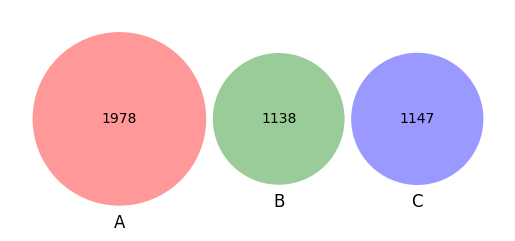

In [20]:
venn3([
    set(part_first['smiles'].tolist()),
    set(part_second['smiles'].tolist()),
    set(part_third['smiles'].tolist()),
])

In [21]:
test_1 = pd.concat([part_first, part_second])
train_1 = part_third.copy()

test_2 = pd.concat([part_first, part_third])
train_2 = part_second.copy()

test_3 = pd.concat([part_second, part_third])
train_3 = part_first.copy()

In [24]:
train_1 = train_1[:500]
train_2 = train_2[:500]
train_3 = train_3[:500]

In [26]:
min_vertex_k_cut.test_split(train_1['smiles'], test_1['smiles'], threshold=0.4)
min_vertex_k_cut.test_split(train_2['smiles'], test_2['smiles'], threshold=0.4)
min_vertex_k_cut.test_split(train_3['smiles'], test_3['smiles'], threshold=0.4)

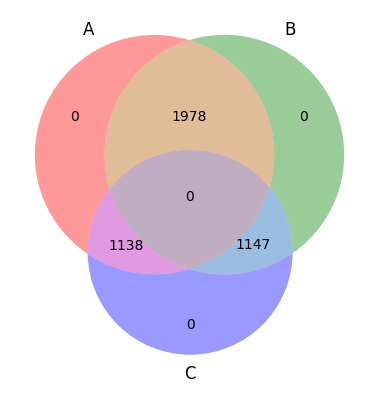

In [27]:
venn3([
    set(test_1['smiles'].tolist()),
    set(test_2['smiles'].tolist()),
    set(test_3['smiles'].tolist()),
])

In [28]:
train_1.to_csv('../../data/hi/kdr/train_1.csv')
train_2.to_csv('../../data/hi/kdr/train_2.csv')
train_3.to_csv('../../data/hi/kdr/train_3.csv')

In [29]:
test_1.to_csv('../../data/hi/kdr/test_1.csv')
test_2.to_csv('../../data/hi/kdr/test_2.csv')
test_3.to_csv('../../data/hi/kdr/test_3.csv')